# Thực hiện đọc dữ liệu từ hdfs

Dữ liệu đã được lưu trữ trên hdfs, hiện tại ta cần sử dụng pyspark để đọc dữ liệu ra và xử lý. Cụm spark đã được bật, ta có thể xem thông tin của cả cụm trên web ui host post của spark-master là 0.0.0.0:8080 (truy cập qua localhost) hoặc 172.19.0.2:8080 (truy cập qua ip của container trong docker, xem thông tin bằng lệnh docker network inspect).

In [ ]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as F 
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from pyspark.sql import SparkSession

try:
    spark.stop()
except:
    pass

spark = SparkSession.builder \
    .appName("Stock_price_analysis") \
    .master("local[*]") \
    .getOrCreate()

In [ ]:
df = spark.read.option("header", True).option("inferSchema", True).csv("hdfs://namenode:9000/datack/*.csv")
df.show(5)

+----------+----+----+----+-----+------+
|      date|open|high| low|close|volume|
+----------+----+----+----+-----+------+
|2006-01-19|2.15|2.15|2.15| 2.15|109350|
|2006-01-20|2.23|2.23|2.19| 2.19|157840|
|2006-01-23|2.19|2.19|2.13| 2.13| 81400|
|2006-01-24|2.13|2.13|2.11| 2.11| 66000|
|2006-01-25|2.11|2.15|2.11| 2.15| 57220|
+----------+----+----+----+-----+------+
only showing top 5 rows



Tiếp theo ta sẽ sử dụng spark session vừa tạo để truy cập vào hdfs và lấy dữ liệu ra để xử lý. Cụ thể ta sẽ truy cập vào địa chỉ của namenode trên hdfs là namenode:9000 

# Một số phân tích cơ bản

Ta lấy dữ liệu dataframe từ spark như thông thường.

Ở đây ta so sánh 10 dữ liệu chứng khoán trong vnstock

tickers = ["VIC", "VHM", "VNM", "HPG", "VCB", "BID", "CTG", "MBB", "TCB"


Kết quả so sánh chỉ số trung bình trong ngày của các mã nói trên trong đồ thị

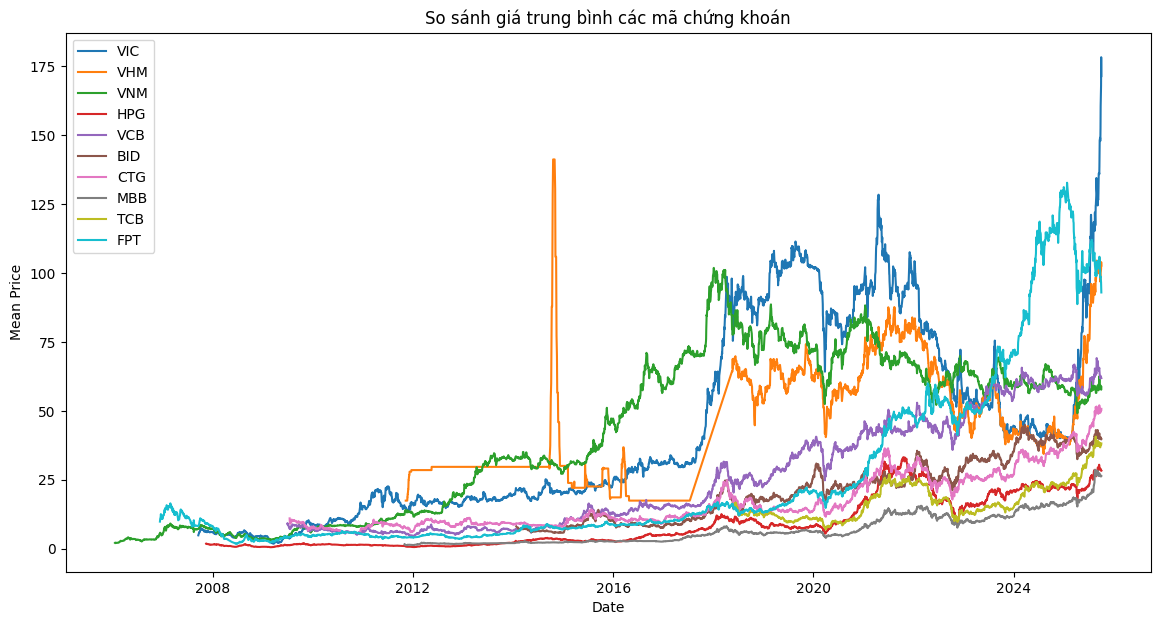

In [5]:
from pyspark.sql.functions import expr, when
import pandas as pd
import matplotlib.pyplot as plt

tickers = ["VIC", "VHM", "VNM", "HPG", "VCB", "BID", "CTG", "MBB", "TCB", "FPT"]

df = df.withColumn("Ticker",
                   when(expr("input_file_name() like '%VIC%'"), "VIC")
                  .when(expr("input_file_name() like '%VHM%'"), "VHM")
                  .when(expr("input_file_name() like '%VNM%'"), "VNM")
                  .when(expr("input_file_name() like '%HPG%'"), "HPG")
                  .when(expr("input_file_name() like '%VCB%'"), "VCB")
                  .when(expr("input_file_name() like '%BID%'"), "BID")
                  .when(expr("input_file_name() like '%CTG%'"), "CTG")
                  .when(expr("input_file_name() like '%MBB%'"), "MBB")
                  .when(expr("input_file_name() like '%TCB%'"), "TCB")
                  .when(expr("input_file_name() like '%FPT%'"), "FPT")
                  .otherwise("Unknown"))

df = df.withColumn("Mean", expr("(high + low)/2"))

pdf = df.select("date", "Mean", "Ticker").toPandas()
pdf['date'] = pd.to_datetime(pdf['date'])

plt.figure(figsize=(14,7))
for code in tickers:
    subset = pdf[pdf['Ticker'] == code]
    plt.plot(subset['date'], subset['Mean'], label=code)

plt.xlabel("Date")
plt.ylabel("Mean Price")
plt.title("So sánh giá trung bình các mã chứng khoán")
plt.legend()
plt.show()

Sau đó, ta vẽ biểu đồ cột thể hiện sự thay đổi của các mã theo ngày

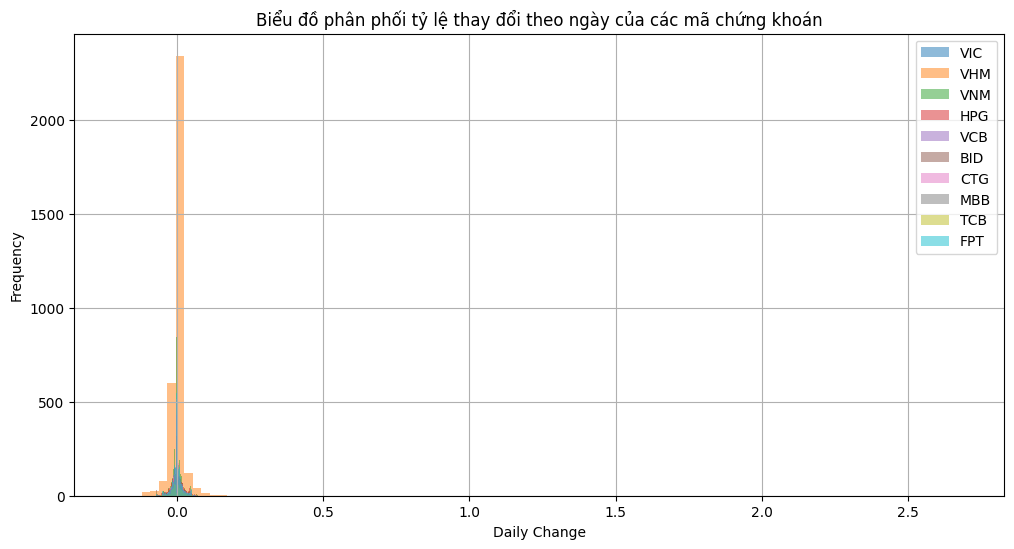

In [6]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag
import matplotlib.pyplot as plt

window = Window.partitionBy("Ticker").orderBy("date")
df = df.withColumn("Change", (col("close") / lag("close").over(window)) - 1)

pdf = df.select("Ticker", "Change").toPandas()

plt.figure(figsize=(12,6))
for code in tickers:
    subset = pdf[pdf['Ticker'] == code]
    subset['Change'].hist(bins=100, alpha=0.5, label=code)

plt.xlabel("Daily Change")
plt.ylabel("Frequency")
plt.title("Biểu đồ phân phối tỷ lệ thay đổi theo ngày của các mã chứng khoán")
plt.legend()
plt.show()


Biểu đồ trên thể hiện sự biến động của từng mã. Số lượng gần 0 càng nhiều chứng tỏ là mã càng biến động ít và ngược lại.

Ta vẽ biểu đồ đường để miêu tả rõ hơn điều đó

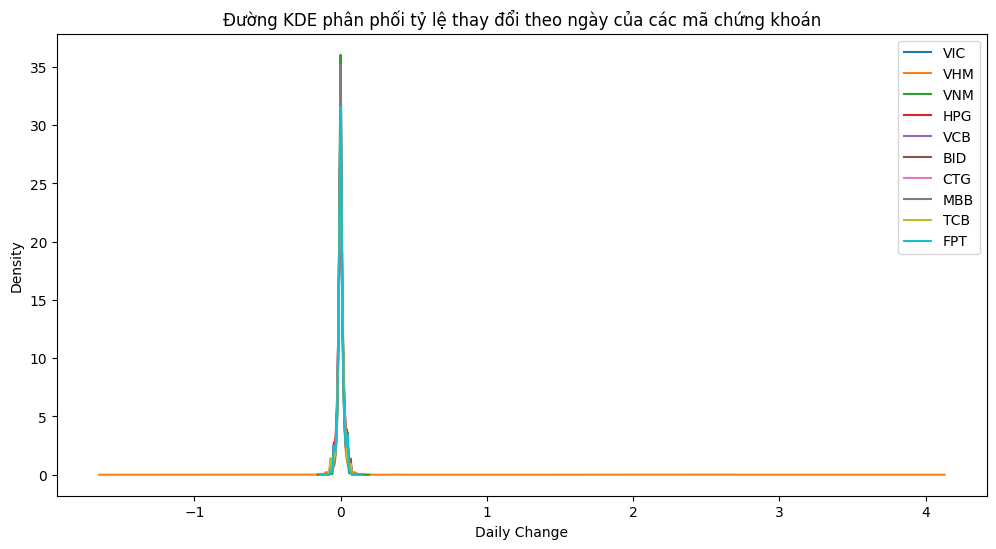

In [7]:
plt.figure(figsize=(12,6))
for code in tickers:
    subset = pdf[pdf['Ticker'] == code]
    subset['Change'].plot(kind='kde', label=code)

plt.xlabel("Daily Change")
plt.ylabel("Density")
plt.title("Đường KDE phân phối tỷ lệ thay đổi theo ngày của các mã chứng khoán")
plt.legend()
plt.show()


# Dùng mô hình học máy để dự đoán tình hình chứng khoán

Trong phần này sẽ tính giá trị trung bình của cổ phiếu VNM. Rồi sử dụng một mô hình học máy đơn giản để dự đoán giá cổ phiếu trung bình của công ty. Chúng em dùng các thông tin từ trước năm 2024 cho việc training và thông tin của năm 2024,2025 cho việc testing.

In [51]:
import pandas as pd

df_VNM = df.filter(df.Ticker == "VNM").select("date", "high", "low", "close")

df_VNM = df_VNM.withColumn("Mean", (df_VNM["high"] + df_VNM["low"]) / 2)

pdf_VNM = df_VNM.toPandas()

pdf_VNM['date'] = pd.to_datetime(pdf_VNM['date'])

pdf_VNM = pdf_VNM.sort_values('date').reset_index(drop=True)

pdf_VNM.head()


,date,high,low,close,Mean
0,2006-01-19,2.15,2.15,2.15,2.15
1,2006-01-20,2.23,2.19,2.19,2.21
2,2006-01-23,2.19,2.13,2.13,2.16
3,2006-01-24,2.13,2.11,2.11,2.12
4,2006-01-25,2.15,2.11,2.15,2.13


In [52]:
train = pdf_VNM[pdf_VNM['date'].dt.year < 2024].copy()
test  = pdf_VNM[pdf_VNM['date'].dt.year >= 2024].copy()

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 4477
Test size: 434


In [53]:
train.head()

,date,high,low,close,Mean
0,2006-01-19,2.15,2.15,2.15,2.15
1,2006-01-20,2.23,2.19,2.19,2.21
2,2006-01-23,2.19,2.13,2.13,2.16
3,2006-01-24,2.13,2.11,2.11,2.12
4,2006-01-25,2.15,2.11,2.15,2.13


In [54]:
test.head()

,date,high,low,close,Mean
4477,2024-01-02,59.82,59.29,59.64,59.555
4478,2024-01-03,60.25,59.38,60.25,59.815
4479,2024-01-04,60.69,60.25,60.25,60.470
4480,2024-01-05,60.52,59.82,60.08,60.170
4481,2024-01-08,60.34,59.56,59.56,59.950


In [55]:
# Import thư viện cơ bản
import numpy as np

if not hasattr(np, 'bool'):
    np.bool = bool

import matplotlib.pyplot as plt
import pandas as pd
import os
from os import path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [56]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

training_set = train[['Mean']].values
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)


Tạo dữ liệu train, X = 60 time steps, Y =  1 time step, có nghĩa lấy dữ liệu của 60 ngày trước để dự đoán cho ngày tiếp theo hay có thể hiểu là lấy 60 ngày trước làm đầu vào, và đầu ra của mô hình sẽ là ngày tiếp theo

In [57]:
import numpy as np

X_train = []
y_train = []
no_of_sample = len(training_set)

for i in range(60, no_of_sample):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [ ]:
# Xây dựng model LSTM
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [64]:
# Nếu tồn tại model thì load lại nếu không thì thực hiện train
if path.exists("mymodel.h5"):
    regressor.load_weights("mymodel.h5")
else:
    regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)
    regressor.save("mymodel.h5")

In [65]:
dataset_test = test.copy()
real_stock_price = dataset_test[['Mean']].values

In [66]:
dataset_total = pd.concat((train['Mean'], test['Mean']), axis=0)
inputs = dataset_total[len(dataset_total) - len(test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

X_test = []
no_of_sample = len(inputs)
for i in range(60, no_of_sample):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

real_stock_price = test[['Mean']].values


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


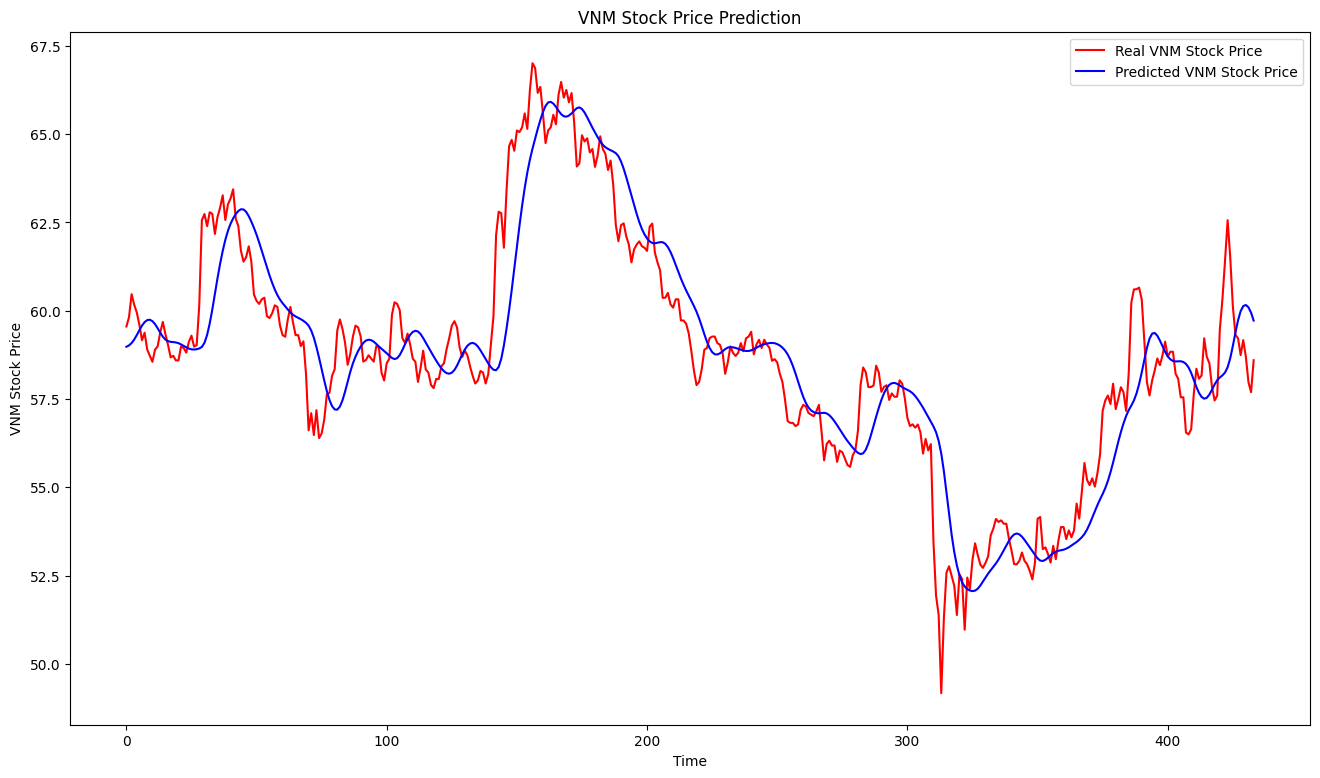

In [67]:
# Ve bieu do gia that va gia du doan
plt.figure(figsize=(16,9))
plt.plot(real_stock_price, color = 'red', label = 'Real VNM Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted VNM Stock Price')
plt.title('VNM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VNM Stock Price')
plt.legend()
plt.show()